In [1]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from mpl_toolkits import mplot3d as mpl3d
from scipy import signal, stats, linalg, fft
import tqdm

# import our 'specsens' package with the help of 'sys'
import sys
sys.path.insert(0, '..')
import specsens as ss

In [2]:
# mpl.use("pgf")  # to display graphs remove this line
mpl.rcParams.update({
    'pgf.texsystem': 'pdflatex',
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
line = 0.75

In [3]:
# general settings for signal and noise
length = .5  # in s
noise_power = 0.0  # in dB
num_bands = 10

# create 'WidebandSignal' object
wbs = ss.WidebandSignal(t_sec=length, num_bands=num_bands, num_steps=10)

# signal power matrix (dimensions: num_bands x num_steps)
mat = np.array([[-100, -100,   -3,    0,    3, -100, -100, -100, -100, -100],
                [-100, -100, -100, -100, -100, -100,    0,    5, -100,    0],
                [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
                [-100,    0,    3,    3, -100, -100, -100, -100, -100, -100],
                [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
                [-100, -100,    1,    4,    7,    4,    1,   -3, -100, -100],
                [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
                [-100, -100, -100, -100, -100,    0,    0, -100, -100, -100],
                [-100,    5,    0,    5, -100, -100, -100, -100, -100, -100],
                [   0,    0,    0, -100, -100, -100, -100, -100, -100, -100]])

# # plot the matrix
# wbs.plot(mat)

# generate actual signal from matrix
sig, sample_freq = wbs.signal(mat)

# create the noise
wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length)
noise = wgn.signal(power=noise_power, dB=True)

# ensure noise and signal have same length (and create global variable 'num_samples')
assert wbs.num_samples == wgn.num_samples
num_samples = wbs.num_samples

# create actual signal ('both') comprising of signal and additive white Gaussian noise (AWGN)
both = sig + noise

# print some info about signal and noise
print('Signal power: %.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:  %.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:          %.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Num samples:  %d ' % (num_samples))

# ensure that Parseval's theorem holds
ss.util.check_parseval(both, length, sample_freq)

Created WidebandSignal with 1.0 MHz total bandwidth and 50000 samples per step.
Signal power: 5.78 dB
Noise power:  0.01 dB
SNR:          5.78 dB
Num samples:  500000 


In [4]:
# use edge detection in spectrum in oder to detect spectrum areas of interest
fft_len = 1024

# create a Short Time Fourier Transform object
sft = ss.Stft(n=fft_len, window='flattop')

# use the stft to transform the signal into the frequency domain
f, t, x = sft.spectogram(both, sample_freq, normalized=False, dB=False)

# Variable Band Energy Detector
vbed = ss.VariableBandEnergyDetector(
    fft_len=fft_len,
    freqs=f,
    noise_power=noise_power,
    pfa=0.1,  # !!! has no real meaning here anymore 
    smooth=5.,  # number of ffts used for smoothing
    scale=4,  # number of multi-scale wavelet products
    min_height=0.1,  # min height required
    energy_compensation=0.2)  # compensate for leaking energy

# empty overlay picture of edges in spectrum
res = np.empty(shape=(len(f), len(t)))
res[:] = np.nan

# empty detection results
det = np.array([])

# go over spectrum ('in time') and detect
for i, _ in enumerate(tqdm.tqdm(t)):

    # do actual detection
    ps, peak, peakf, dics = vbed.detect(x[:, i])

    # store edges in res
    res = ss.util_wide.store_pic(pic=res,
                                 x=i,
                                 y=peak,
                                 n=3,
                                 val=1.,
                                 minimum=0,
                                 maximum=len(f))

    # store detection results in det
    det = np.append(det, dics)

# print some band stats
idx = 90
print('Entries of %dth fft at time %.3fs: ' % (idx, idx * (t[1] - t[0])))
for j, d in enumerate(det[idx].items()):
    print('--- Entry number %d ---' % (j))
    print('Band center freq: %.2f' % (f[d[0]]))
    print('Energy in band:   %.2f' % (d[1][0]))
    print('Band upper freq:  %.2f' % (f[d[1][1]]))
    print('Band lower freq:  %.2f' % (f[d[1][2]]))
    print('Band width:       %.2f' % (d[1][3] * (f[1] - f[0])))

100%|██████████| 488/488 [00:01<00:00, 421.02it/s]

Entries of 90th fft at time 0.092s: 
--- Entry number 0 ---
Band center freq: -151367.19
Energy in band:   1048.54
Band upper freq:  -169921.88
Band lower freq:  -131835.94
Band width:       38085.94
--- Entry number 1 ---
Band center freq: 348632.81
Energy in band:   3195.52
Band upper freq:  329101.56
Band lower freq:  368164.06
Band width:       39062.50
--- Entry number 2 ---
Band center freq: 450195.31
Energy in band:   1058.43
Band upper freq:  428710.94
Band lower freq:  471679.69
Band width:       42968.75


100%|██████████| 488/488 [00:07<00:00, 61.78it/s]


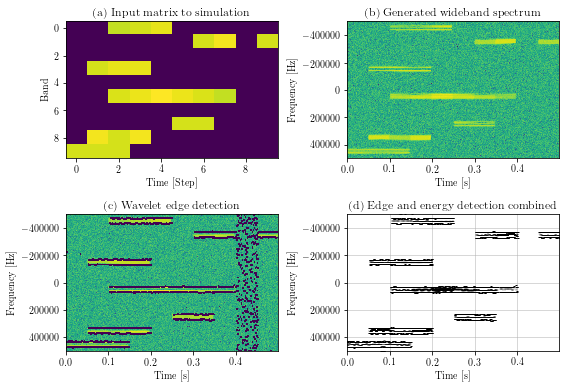

In [5]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 5.5))

img = axs[0, 0].imshow(mat, aspect='auto')
axs[0, 0].set_xlabel(r'Time [Step]')
axs[0, 0].set_ylabel(r'Band')
axs[0, 0].set_title(r'(a) Input matrix to simulation')
# cbar = plt.colorbar(img, ax=axs[0, 0])
# cbar.set_label(r'Power [dB]')

sft = ss.Stft(n=1024, window='flattop')
ftmp, ttmp, xtmp = sft.spectogram(both, sample_freq, normalized=True, dB=True)
axs[0, 1].pcolormesh(ttmp,
                     ftmp,
                     xtmp,
                     cmap='viridis',
                     vmin=np.min(xtmp),
                     vmax=np.max(xtmp))
axs[0, 1].set_xlabel(r'Time [s]')
axs[0, 1].set_ylabel(r'Frequency [Hz]')
axs[0, 1].set_title(r'(b) Generated wideband spectrum')
axs[0, 1].invert_yaxis()

axs[1, 0].pcolormesh(t,
                     f,
                     ss.util.dB_power(x),
                     cmap='viridis',
                     vmin=np.min(ss.util.dB_power(x)),
                     vmax=np.max(ss.util.dB_power(x)))
axs[1, 0].pcolormesh(t, f, res, cmap='viridis')
axs[1, 0].set_xlabel('Time [s]')
axs[1, 0].set_ylabel('Frequency [Hz]')
axs[1, 0].set_title(r'(c) Wavelet edge detection')
axs[1, 0].set_xlim([np.min(t), np.max(t)])
axs[1, 0].set_ylim([np.min(f), np.max(f)])
axs[1, 0].invert_yaxis()

for i, dic in enumerate(tqdm.tqdm(det)):
    for j, d in enumerate(dic.items()):
        axs[1, 1].plot(t[i], f[int(d[1][1])], 'k_', markersize=2)
        axs[1, 1].plot(t[i],
                       f[int(d[0])],
                       'k_',
                       markersize=2,
                       markeredgewidth=d[1][0] / 2000)
        axs[1, 1].plot(t[i], f[int(d[1][2])], 'k_', markersize=2)
axs[1, 1].set_xlabel(r'Time [s]')
axs[1, 1].set_ylabel(r'Frequency [Hz]')
axs[1, 1].set_title(r'(d) Edge and energy detection combined')
axs[1, 1].grid(linewidth=0.5)
axs[1, 1].set_xlim([np.min(t), np.max(t)])
axs[1, 1].set_ylim([np.min(f), np.max(f)])
axs[1, 1].invert_yaxis()
# axs[1, 1].axvline(0.092,
#                   c='C1',
#                   alpha=0.5,
#                   ls='--',
#                   linewidth=1,
#                   aa=True)

plt.tight_layout()
plt.savefig('out/chap5/wideband_edge.png', dpi=1200)

In [6]:
# general settings for signal and noise
length = .5  # in s
noise_power = 10.0  # in dB
num_bands = 10

# create 'WidebandSignal' object
wbs = ss.WidebandSignal(t_sec=length, num_bands=num_bands, num_steps=10)

# signal power matrix (dimensions: num_bands x num_steps)
mat = np.array([[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
                [-100, -100,   -3,    0,    3,    5,    7,   10, -100, -100],
                [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
                [-100,    0,    3,    3,    0, -100,    0,    5,    0, -100],
                [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
                [-100, -100,   10,    5,    0,   -5,   -7,  -10,  -13, -100],
                [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100],
                [-100, -100, -100, -100, -100,    0,    0, -100, -100, -100],
                [-100,   10,   10,   10, -100, -100, -100, -100, -100, -100],
                [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100]])

# # plot the matrix
# wbs.plot(mat)

# generate actual signal from matrix
sig, sample_freq = wbs.signal(mat)

# create the noise
wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length)
noise = wgn.signal(power=noise_power, dB=True)

# ensure noise and signal have same length (and create global variable 'num_samples')
assert wbs.num_samples == wgn.num_samples
num_samples = wbs.num_samples

# create actual signal ('both') comprising of signal and additive white Gaussian noise (AWGN)
both = sig + noise

# print some info about signal and noise
print('Signal power: %.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:  %.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:          %.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Num samples:  %d ' % (num_samples))

# ensure that Parseval's theorem holds
ss.util.check_parseval(both, length, sample_freq)

Created WidebandSignal with 1.0 MHz total bandwidth and 50000 samples per step.
Signal power: 8.87 dB
Noise power:  9.99 dB
SNR:          -1.12 dB
Num samples:  500000 


In [7]:
# use edge detection in spectrum in oder to detect spectrum areas of interest
fft_len = 1024

# create a Short Time Fourier Transform object
sft = ss.Stft(n=fft_len, window='flattop')

# use the stft to transform the signal into the frequency domain
f, t, x = sft.spectogram(both, sample_freq, normalized=False, dB=False)

# Variable Band Energy Detector
vbed = ss.VariableBandEnergyDetector(
    fft_len=fft_len,
    freqs=f,
    noise_power=noise_power,
    pfa=0.95,  # !!! has no real meaning here anymore 
    smooth=5.,  # number of ffts used for smoothing
    scale=4,  # number of multi-scale wavelet products
    min_height=0.1,  # min height required
    energy_compensation=0.2)  # compensate for leaking energy

# empty overlay picture of edges in spectrum
res = np.empty(shape=(len(f), len(t)))
res[:] = np.nan

# empty detection results
det = np.array([])

# go over spectrum ('in time') and detect
for i, _ in enumerate(tqdm.tqdm(t)):

    # do actual detection
    ps, peak, peakf, dics = vbed.detect(x[:, i])

    # store edges in res
    res = ss.util_wide.store_pic(pic=res,
                                 x=i,
                                 y=peak,
                                 n=3,
                                 val=1.,
                                 minimum=0,
                                 maximum=len(f))

    # store detection results in det
    det = np.append(det, dics)

# print some band stats
idx = 90
print('Entries of %dth fft at time %.3fs: ' % (idx, idx * (t[1] - t[0])))
for j, d in enumerate(det[idx].items()):
    print('--- Entry number %d ---' % (j))
    print('Band center freq: %.2f' % (f[d[0]]))
    print('Energy in band:   %.2f' % (d[1][0]))
    print('Band upper freq:  %.2f' % (f[d[1][1]]))
    print('Band lower freq:  %.2f' % (f[d[1][2]]))
    print('Band width:       %.2f' % (d[1][3] * (f[1] - f[0])))

100%|██████████| 488/488 [00:01<00:00, 409.87it/s]

Entries of 90th fft at time 0.092s: 
--- Entry number 0 ---
Band center freq: 348632.81
Energy in band:   10387.18
Band upper freq:  329101.56
Band lower freq:  368164.06
Band width:       39062.50


100%|██████████| 488/488 [00:03<00:00, 145.31it/s]


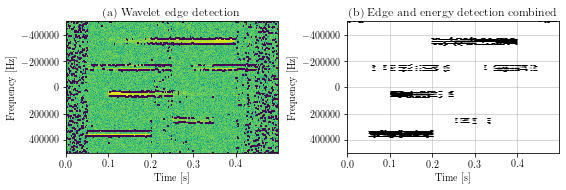

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 2.75))

axs[0].pcolormesh(t,
                  f,
                  ss.util.dB_power(x),
                  cmap='viridis',
                  vmin=np.min(ss.util.dB_power(x)),
                  vmax=np.max(ss.util.dB_power(x)))
axs[0].pcolormesh(t, f, res, cmap='viridis')
axs[0].set_xlabel(r'Time [s]')
axs[0].set_ylabel(r'Frequency [Hz]')
axs[0].set_title(r'(a) Wavelet edge detection')
axs[0].set_xlim([np.min(t), np.max(t)])
axs[0].set_ylim([np.min(f), np.max(f)])
axs[0].invert_yaxis()

for i, dic in enumerate(tqdm.tqdm(det)):
    for j, d in enumerate(dic.items()):
        axs[1].plot(t[i], f[int(d[1][1])], 'k_', markersize=2)
        axs[1].plot(t[i],
                    f[int(d[0])],
                    'k_',
                    markersize=2,
                    markeredgewidth=d[1][0] / 3000)
        axs[1].plot(t[i], f[int(d[1][2])], 'k_', markersize=2)
axs[1].set_xlabel(r'Time [s]')
axs[1].set_ylabel(r'Frequency [Hz]')
axs[1].set_title(r'(b) Edge and energy detection combined')
axs[1].grid(linewidth=0.5)
axs[1].set_xlim([np.min(t), np.max(t)])
axs[1].set_ylim([np.min(f), np.max(f)])
axs[1].invert_yaxis()

plt.tight_layout()
plt.savefig('out/chap5/wideband_edge_low_snr.png', dpi=1200)